In [131]:
import pickle
import os

import pandas as pd
import numpy as np

data_dir = '/opt/ml/input/data/eval/'
pickle_path = os.path.join(output_dir, 'mg_v1.pickle')
info_path = os.path.join(data_dir, 'info.csv')

info = pd.read_csv(info_path).sort_values(by='ImageID')
output_dir = '/opt/ml/submission'

with open(os.path.join(output_dir, 'ensemble.pickle'), "rb") as f:
    pred = pickle.load(f)
    print(pred[:10])

# with open(pickle_path, "rb") as f:
#     mg_pred = pickle.load(f)
#     final_pred = mg_pred + pred

# info['ans'] = final_pred
# info.sort_index(inplace=True)

# sub_name = 'submission_v28(soft_vote).csv'
# info.to_csv(os.path.join(output_dir, sub_name), index=False)
# print('test inference is done.')

[0 0 2 0 2 0 0 0 2 0]


In [2]:
import os
import numpy as np
import pandas as pd
import albumentations
import albumentations.pytorch
import cv2
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomRotation

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
test_dir = '/opt/ml/input/data/eval/'

In [86]:
# df1 = pd.read_csv('/opt/ml/submission/resnext101_submission.csv')
# df1 = pd.read_csv('/opt/ml/submission/effb0_submission.csv')
# df1 = pd.read_csv('/opt/ml/submission/effb4_submission.csv')
# df2 = pd.read_csv('/opt/ml/submission/resnext101_submission.csv')
# df1 = pd.read_csv('/opt/ml/submission/multihead_resnext50_submission.csv')
# df1 = pd.read_csv('/opt/ml/submission/multihead_effb0_v10_submission.csv')
# df2 = pd.read_csv('/opt/ml/submission/multihead_effb0_v10_aug_submission.csv')
df2 = pd.read_csv('/opt/ml/submission/multihead_effb0_v10_aug_submission.csv')
# df1 = pd.read_csv('/opt/ml/submission/soft_ensemble_submission.csv')
df2 = pd.read_csv('/opt/ml/submission/multihead_effb0_final_aug_submission.csv')
df1 = pd.read_csv('/opt/ml/submission/multihead_effb4_final_aug_submission.csv')

df2 = df2.rename(columns={'ans':'ans2'})['ans2']
df = pd.concat([df1, df2], axis=1)
# df.head()

df = df[df['ans'] != df['ans2']]
len(df)

1749

## Ensemble 코드

In [48]:
##ensemble 

images = pd.read_csv('/opt/ml/submission/submission_v11_reload.csv')['ImageID']
ans1 = pd.read_csv('/opt/ml/submission/submission_v11_reload.csv')['ans']
ans2 = pd.read_csv('/opt/ml/submission/submission_v12.csv')['ans']
ans3 = pd.read_csv('/opt/ml/submission/submission_v13.csv')['ans']

df = pd.concat([images, ans1, ans2, ans3], axis=1)

answers = []
for idx, (img, a1, a2, a3) in enumerate(zip(images, ans1, ans2, ans3)):
    ans = 0
    if a1 == a2: ans = a1
    elif a2 == a3: ans = a2
    elif a1 == a3: ans = a3
    else: ans = int(round((a1 + a2 + a3) / 3))
    
    answers.append(ans)

# submission = pd.read_csv('/opt/ml/submission/submission_v11_reload.csv')
# submission['ans'] = np.array(answers)
# submission.head()

# submission.to_csv('/opt/ml/submission/submission_v24.csv', index=False)

####

## 임의 개수 이상 Ensemble

In [90]:
## V31 name_list = ['submission_v11_reload.csv', 'submission_v12.csv', 'submission_v13.csv', 'submission_v16.csv', 'submission_v28(soft_vote).csv']
## V32 name_list = ['submission_v11_reload.csv', 'submission_v12.csv', 'submission_v13.csv', 'submission_v16.csv', 'submission_v28(soft_vote).csv', 'submission_v30(ensemble)']
# # V35
# name_list = ['multihead_resnext50_final_aug_submission.csv', 
#             'multihead_resnext50_final_submission.csv',
#             'multihead_effb0_final_aug_submission.csv',
#             'multihead_effb0_final_submission.csv',
#             'submission_v31(ensemble).csv',
#             'submission_v11_reload.csv']
# weights = [1.1, 1.1, 1, 1, 1.1, 0.8]

# name_list = ['multihead_resnext50_final_aug_submission.csv', 
#             'multihead_resnext50_final_submission.csv',
#             'submission_v31(ensemble).csv',
#             'multihead_effb0_final_aug_submission.csv',
#             'multihead_effb0_final_submission.csv',
#             'submission_v11_reload.csv',
#             ]
# weights = [1.1, 1.1, 1.1, 1, 1, 0.8]
# # V36
# name_list = ['multihead_resnext50_final_aug_submission.csv', 
#             'multihead_resnext50_final_submission.csv',
#             'submission_v31(ensemble).csv',
#             'multihead_effb0_final_aug_submission.csv',
#             'multihead_effb0_final_submission.csv',
#             'submission_v33(ensemble).csv']

# weights = [1.1, 1.1, 1.1, 0.8, 0.8, 1]
##

##

import random
from collections import defaultdict

root_dir = '/opt/ml/submission/'
###
sub_name = '/opt/ml/submission/submission_v37(ensemble).csv'
###

# V37
name_list = ['multihead_resnext50_final_aug_submission.csv', 
             'multihead_effb0_final_aug_submission.csv',
             'submission_v31(ensemble).csv']
weights = [1.01, 1.0, 1.0]
##

df = pd.read_csv('/opt/ml/submission/submission_v11_reload.csv')['ImageID']
for idx, name in enumerate(name_list):
    path = os.path.join(root_dir, name)
    ans = pd.read_csv(path)['ans']
    ans.rename(f"ans_{idx + 1}", inplace=True)
    df = pd.concat([df, ans], axis=1)
    
# df.iloc[:, 1:].head()

final_ans = []
for _, answers in df.iloc[:, 1:].iterrows():
    vote = defaultdict(int)
    for answer, weight in zip(answers, weights):
        vote[answer] += weight
    vote = sorted(vote.items(), key=lambda x: x[1], reverse=True)
    
    ans = 0
    if len(vote) > 1 and vote[0][1] == vote[1][1]:
        print(vote[0][1], vote[1][1])
        ans = vote[0][0] if random.random() > 0.5 else vote[1][0]
    else:
        ans = vote[0][0]
    final_ans.append(ans)
    
submission = pd.read_csv('/opt/ml/submission/submission_v11_reload.csv')
submission['ans'] = np.array(final_ans)
submission.head()

submission.to_csv(sub_name, index=False)
print(f"{sub_name} is created.")

####

/opt/ml/submission/submission_v37(ensemble).csv is created.


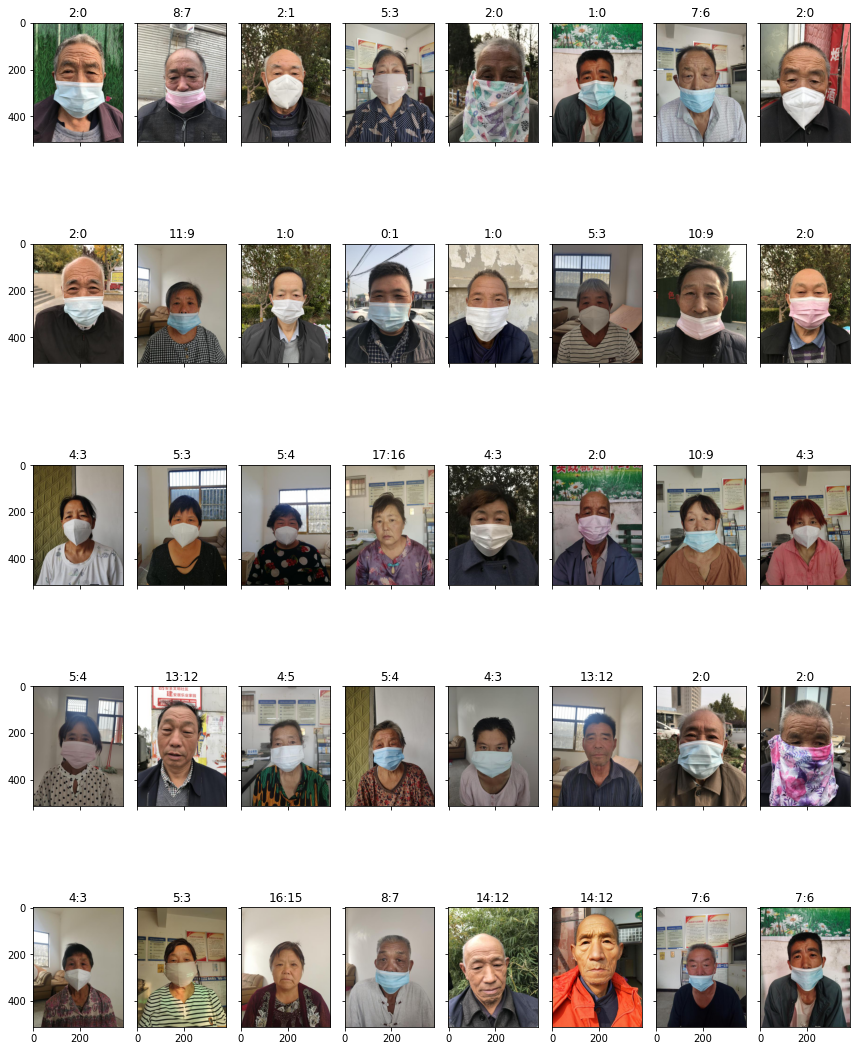

In [30]:
# fig, axs = plt.subplots(figsize=(12, 16), nrows=4, ncols=4, sharex=True, sharey=True)

# for X, y in dataloaders['train'][0]:
#     for i, (X, y) in enumerate(zip(X[:16], y[:16])):
#         axs[i % 4][i // 4].imshow(X.permute(1, 2, 0))
#         axs[i % 4][i // 4].set_title(str(y))
#     break
# 


nrows=5
ncols=8

fig, axs = plt.subplots(figsize=(12, 16), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

for i in range(nrows*ncols):
    label1 = df.iloc[i, 1]
    label2 = df.iloc[i, 2]
    img_name = df.iloc[i, 0]
    img_name = os.path.join(test_dir, 'images/', img_name)
    image = Image.open(img_name)
    
    axs[i // ncols][i % ncols].imshow(image)
    axs[i // ncols][i % ncols].set_title(f"{label1}:{label2}")
    
plt.tight_layout()
plt.show()